In [ ]:
# Import libraries and configure matplotlib

import numpy as np
import pandas as pd
import random
import os
from scipy import optimize
import scipy
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set()


plt.rc('font', family = 'serif')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize'] =20 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load data set

path = "/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2"

files = ["inst_choices.csv","inst_outcomes.csv","stai_scores.csv"]

trials = ["Trial " + str(i) for i in range(160)]
choices = pd.read_csv(os.path.join(path,files[0]),names = trials)
outcomes = pd.read_csv(os.path.join(path,files[1]),names = trials)
stai = pd.read_csv(os.path.join(path,files[2]),names = ["Scores"])

## Task A

In [ ]:
print("STAI-Y2 mean: ",stai["Scores"].mean())
print("STAI-Y2 standard deviation: ",round(stai["Scores"].std(),2))
print("STAI-Y2 median: ",stai["Scores"].median())

In [ ]:
cutoff = 43
print("Number of participants considered healthy controls: ",len(stai[stai['Scores'] <= cutoff]))

In [ ]:
print("Indices of control subjects")
print(stai[stai['Scores'] <= cutoff].index)
print("Participants do fit in the correct group except for two participants: participant 21 is from the 'calm' group \
      and participant 26 is from the 'anxious' group ")

In [ ]:
# Number of times each participant chose option A

#### creating one hot encoding version of choices. A = 0, B = 1
choices_oh = choices-1
####
(1-choices_oh).mean(axis=1)

In [ ]:
print("Average selection of choice A: ",np.round((1-choices_oh).mean(axis=1).mean(),4))

In [ ]:
# Expected number of aversive sounds experienced by participants
phase_0=list(choices_oh)[:40]
phase_1=list(choices_oh)[40:80]
phase_2=list(choices_oh)[80:120]
phase_3=list(choices_oh)[120:160]

summary = (1-choices_oh[phase_0]).sum(axis=1)*0.6+(1-choices_oh[phase_1]).sum(axis=1)*0.8+(1-choices_oh[phase_2]).sum(axis=1)*0.6+\
(1-choices_oh[phase_3]).sum(axis=1)*0.65+\
(choices_oh[phase_0]).sum(axis=1)*0.4+(choices_oh[phase_1]).sum(axis=1)*0.2+(choices_oh[phase_2]).sum(axis=1)*0.4+\
(choices_oh[phase_3]).sum(axis=1)*0.35
# Don't be confused by the cell above. This is the expected number. The cell above shows the proportion over 160 trials


In [ ]:
np.mean(summary)

## Task B

In [ ]:
def outc(action,prob_a,prob_b):
    """
    Outcome function: decides the outcome given choice and probabilities from experiment stage
    action: option selected
    prob_a: probability for option A
    prob_b: probability for option B
    """
    
    if action == 0:
        prob = prob_a
    else:
        prob = prob_b
        
    return int(random.uniform(0,1) < prob)

def rl_gen(alpha, beta, init_v):
    """
    RL model
    """
    v = np.ones(2)*init_v
    prog_v = []
    count = 0
    for i in range(160):
        
        prob_a=0
        if i < 40:
            prob_a = 0.6
        elif i < 80:
            prob_a = 0.8
        elif i < 120:
            prob_a = 0.6
        else:
            prob_a = 0.65
        
        prob_b = 1-prob_a
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        
        if random.uniform(0,1)<p_action_a:
            a = 0
        else:
            a = 1
        
        
        out = outc(a,prob_a,prob_b)
        
        v[a] += alpha*(out-v[a])
        
        prog_v.append(v.copy())
        count +=out
    
    return v,prog_v ,count

In [ ]:
# run simulations

n = 1000
res = []
v_evol = []

for i in range(n):
    v, prog_v,c = rl_gen(0.3,8,0.5)
    
    res.append(v)
    v_evol.append(prog_v)
np.mean(res,axis=0)
v_evol = np.array(v_evol)

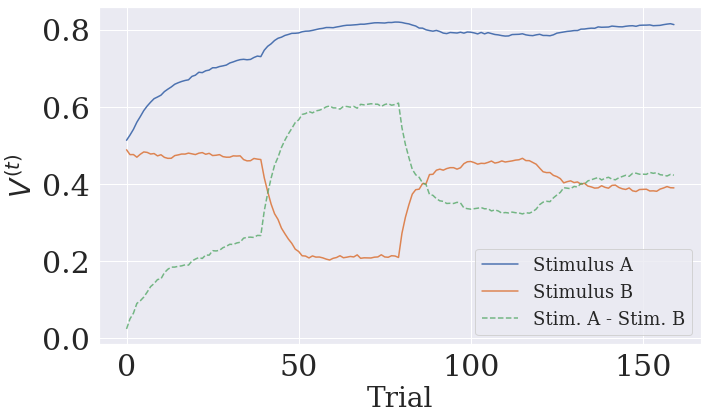

In [469]:
# plot average evolution
fig, ax = plt.subplots(1,1, figsize = (10,6))

avg_evol=v_evol.mean(axis=0)
#std_evol = v_evol.std(axis=0)
ax.plot(avg_evol[:,0], label= "Stimulus A")
#ax[0].fill_between(range(160), avg_evol[:,0]+std_evol[:,0], avg_evol[:,0]-std_evol[:,0],alpha=0.2)
ax.plot(avg_evol[:,1], label= "Stimulus B")
#ax[0].fill_between(range(160), avg_evol[:,1]+std_evol[:,1], avg_evol[:,1]-std_evol[:,1],alpha=0.2)
ax.set_xlabel("Trial",size=28)
ax.set_ylabel(r"$V^{(t)}$",size=28)


ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
#ax.text(0,1.05,"A",transform=ax[0].transAxes,fontsize=34,weight='bold')


#plot average difference evolution
diff_evol = v_evol[:,:,0]-v_evol[:,:,1]
diff_evol=diff_evol.mean(axis=0)
#std_evol = diff_evol.std(axis=0)

ax.plot(diff_evol, label= "Stim. A - Stim. B",linestyle="--",alpha=0.8)
#ax[1].fill_between(range(160), diff_evol+std_evol,  diff_evol-std_evol,alpha=0.2)

#ax[1].text(0,1.05,"B",transform=ax[1].transAxes,fontsize=34,weight='bold')
ax.legend(prop={'size': 18})
plt.tight_layout()
plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig1_.png',dpi=400)


## Task C

In [ ]:
# Simulate hyperparameters
alphas = np.linspace(0.01,0.99,100)
betas = np.linspace(0.01,9.99,100)
ccc_list = []
for alpha in alphas:
    
    cc_list = []
    for beta in betas:
        # run simulations
        
        n = 1000
        c_list = []
        for i in range(n):
            v, prog_v,c = rl_gen(alpha,beta,0.5)
            c_list.append(c)

        cc_list.append(np.mean(c_list))
        
        
    ccc_list.append(cc_list)
ccc_list = np.array(ccc_list)

In [ ]:
# Plot heatmap with aversive counts

fig, ax = plt.subplots(1,1, figsize = (16,12))
sns.heatmap(ccc_list,xticklabels = np.round(betas,2),yticklabels=np.round(alphas,2))
plt.xticks(np.arange(0,len(betas),9) + 0.5)
plt.yticks(np.arange(0,len(alphas),9) + 0.5)
plt.xlabel(r"$\beta$",size=40)
plt.ylabel(r"$\alpha$",size=40)
plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=35)

plt.tight_layout()
plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig2.png',dpi=400)


## Task D

In [ ]:
def log_lh(params,choices,outcomes):
    """
    Log likelihood function for first model
    """
    init_v = 0.5
    v = np.ones(2)*init_v
    prog_v = []
    count = 0
    ll=0
    alpha=params[0]
    beta = params[1]
    for i in range(160):
        
        
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        #ll+=np.log(p_action_a)
        a = choices[i]
        #print(a)
        ll+=np.log((p_action_a**(1-a))*((1-p_action_a)**(a)))
        
        
        
        
        
        v[a] += alpha*(outcomes[i]-v[a])
        
        prog_v.append(v.copy())
        
    return -ll

In [ ]:
# Testing 2nd participant
log_lh([0.3,8],choices_oh.to_numpy()[1,:],outcomes.to_numpy()[1,:])

In [ ]:
# NLL for 1st and 10th participant
first = log_lh([0.3,8],choices_oh.to_numpy()[0,:],outcomes.to_numpy()[0,:])
tenth = log_lh([0.3,8],choices_oh.to_numpy()[9,:],outcomes.to_numpy()[9,:])

print("NLL for first participant: ", np.round(first,2))
print("NLL for tenth participant: ", np.round(tenth,2))


## Task E

In [ ]:
best_params = []
for i in range(50):
    res=optimize.minimize(log_lh,x0=[0.3,8],method='Nelder-Mead',args=(choices_oh.to_numpy()[i,:],outcomes.to_numpy()[i,:]))
    best_params.append(res.x)
best_params = np.array(best_params)

In [ ]:
print("Mean of alpha :",np.mean(best_params[:,0]))
print("Variance of alpha :",np.var(best_params[:,0]))
print("\n")
print("Mean of beta :",np.mean(best_params[:,1]))
print("Variance of beta :",np.var(best_params[:,1]))

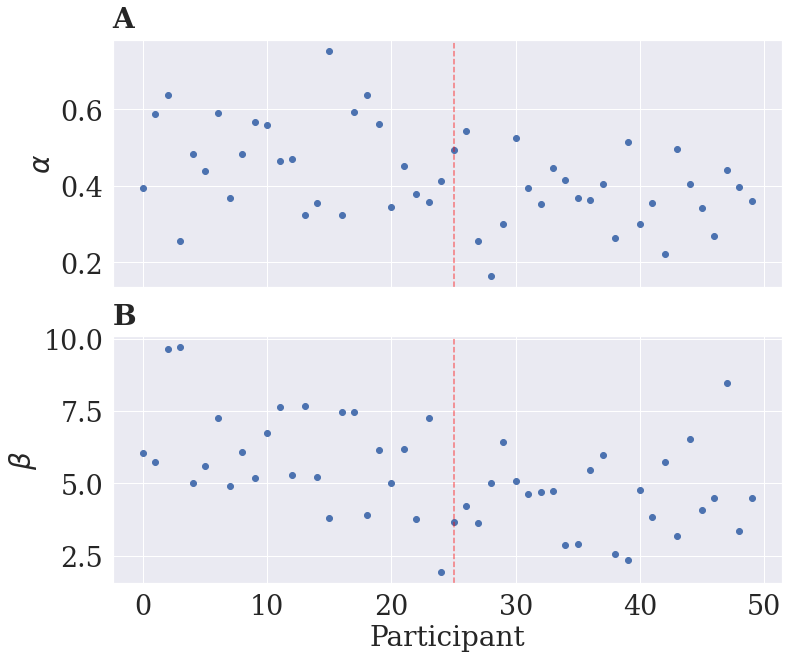

In [465]:
# plot average evolution
fig, ax = plt.subplots(2,1, figsize = (12,10))
ax[0].scatter(range(0,50),best_params[:,0], label= "Alpha")
ax[1].scatter(range(0,50),best_params[:,1], label= "Beta")
ax[0].axvline(x=25,color="red",alpha=0.5,linestyle="--")
ax[1].axvline(x=25,color="red",alpha=0.5,linestyle="--")

#plt.legend(prop={'size': 18})
ax[0].xaxis.set_ticklabels([])
ax[0].tick_params(axis='y', labelsize=27)
ax[1].tick_params(axis='x', labelsize=27)
ax[1].tick_params(axis='y', labelsize=27)
ax[0].set_ylabel(r"$\alpha$",size=28)
ax[1].set_ylabel(r"$\beta$",size=28)
ax[1].set_xlabel("Participant",size=28)


ax[0].text(0,1.05,"A",transform=ax[0].transAxes,fontsize=28,weight='bold')
ax[1].text(0,1.05,"B",transform=ax[1].transAxes,fontsize=28,weight='bold')

plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig3.png',dpi=400)


In [ ]:
# Pearson correlation across all participants

print("Pearson correlation across all participants: ",np.round(np.corrcoef(best_params.T)[0,1],4))
print("Pearson correlation across high anxiety participants: ",np.round(np.corrcoef(best_params[:25,:].T)[0,1],4))
print("Pearson correlation across low anxiety participants: ",np.round(np.corrcoef(best_params[25:,:].T)[0,1],4))


## Task F

In [ ]:
print("t-statistic for alpha test: ", np.round(scipy.stats.ttest_ind(best_params[:25,:],best_params[25:,:]).statistic[0],4))
print("t-statistic for beta test: ", np.round(scipy.stats.ttest_ind(best_params[:25,:],best_params[25:,:]).statistic[1],4))

print("Degrees of freedom: ",48)
print("p-value for alpha test: ", np.round(scipy.stats.ttest_ind(best_params[:25,:],best_params[25:,:]).pvalue[0],4))
print("p-value for beta test: ", np.round(scipy.stats.ttest_ind(best_params[:25,:],best_params[25:,:]).pvalue[1],4))




## Task G

In [ ]:
def rl_gen_g(alpha, beta, init_v):
    """
    RL for first model to simulate outcome and choices selection
    """
    v = np.ones(2)*init_v
    out_list = []
    action_list = []
    for i in range(160):
        
        prob_a=0
        if i < 40:
            prob_a = 0.6
        elif i < 80:
            prob_a = 0.8
        elif i < 120:
            prob_a = 0.6
        else:
            prob_a = 0.65
        
        prob_b = 1-prob_a
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        
        if random.uniform(0,1)<p_action_a:
            a = 0
        else:
            a = 1
        
        
        out = outc(a,prob_a,prob_b)
        
        v[a] += alpha*(out-v[a])
        
        out_list.append(out)
        action_list.append(a)
        
        
    return out_list, action_list

In [ ]:
# Iterate 5 times calculating Pearson's correlation comparing simulated and fitted parameters

for itera in range(5):

    anx_mean = np.mean(best_params[:25,:],axis=0)
    ctrl_mean = np.mean(best_params[25:,:],axis=0)
    
    overall_median = np.median(best_params,axis=0)
    
    mode = None #set mode to diff if mean are different from the first 25 participants from the last 25


    if mode == "diff":
        

        anx=np.random.multivariate_normal(anx_mean,[[0.01,0],[0,0.5]],size=25)
        ctrl=np.random.multivariate_normal(ctrl_mean,[[0.01,0],[0,0.5]],size=25)

        params = np.vstack((anx,ctrl))
    else:


        params=np.random.multivariate_normal(overall_median,[[0.01,0],[0,0.5]],size=50)

    if itera == 0:
        fig, ax = plt.subplots(1,1, figsize = (12,10))
        ax.scatter(params[:,1],params[:,0])
        ax.tick_params(axis='x', labelsize=27)
        ax.tick_params(axis='y', labelsize=27)
        plt.xlabel(r"$\beta$",size=30)
        plt.ylabel(r"$\alpha$",size=30)
        plt.show()
        fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig4.png',dpi=400)


    outcomes_synth = []
    actions_synth = []
    for param in params:
        
        outcome, actions = rl_gen_g(param[0],param[1],0.5)
        outcomes_synth.append(outcome)
        actions_synth.append(actions)
    outcomes_synth = np.array(outcomes_synth)
    actions_synth = np.array(actions_synth)

    best_params_g = []
    for i in range(50):
        res=optimize.minimize(log_lh,x0=[0.3,8],method='Nelder-Mead',args=(actions_synth[i,:],outcomes_synth[i,:]))
        best_params_g.append(res.x)
    best_params_g = np.array(best_params_g)




    new_alphas = np.vstack((params[:,0],best_params_g[:,0]))
    new_betas = np.vstack((params[:,1],best_params_g[:,1]))
    
    if itera == 0:
        new_alphas_plot = new_alphas
        new_betas_plot = new_betas
    
    print("Pearson correlation between alphas for iteration ",itera+1,": ",np.round(np.corrcoef(new_alphas)[0,1],4))
    print("Pearson correlation between betas for iteration ",itera+1,": ",np.round(np.corrcoef(new_betas)[0,1],4))
    print("\n")

In [ ]:
# Identify outliers
outlim=np.abs(new_betas_plot[0,:]-new_betas_plot[1,:])<2
colors = np.array(["b" if i else "r" for i in outlim])


In [ ]:

# Plot correlation

fig, ax = plt.subplots(1,2, figsize = (14,7))
ax[0].scatter(new_alphas_plot[0],new_alphas_plot[1],c=colors)
ax[1].scatter(new_betas_plot[0],new_betas_plot[1],c=colors)
ax[0].plot([0.1,0.8],[0.1,0.8], ls="--", c="k")
ax[1].plot([3,8],[3,8], ls="--", c="k")
ax[0].tick_params(axis='x', labelsize=25)
ax[0].tick_params(axis='y', labelsize=25)
ax[1].tick_params(axis='x', labelsize=25)
ax[1].tick_params(axis='y', labelsize=25)
ax[0].set_xlabel(r"simulated$ \ \alpha$",size=27)
ax[0].set_ylabel(r"fit$ \ \alpha$",size=27)
ax[1].set_xlabel(r"simulated$ \ \beta$",size=27)
ax[1].set_ylabel(r"fit$ \ \beta$",size=27)
ax[0].text(0,1.05,"A",transform=ax[0].transAxes,fontsize=28,weight='bold')
ax[1].text(0,1.05,"B",transform=ax[1].transAxes,fontsize=28,weight='bold')
plt.tight_layout()
plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig5.png',dpi=400)


## Task H

In [ ]:
# https://www.sciencedirect.com/science/article/pii/S0149763415001311?via%3Dihub
# https://www.nature.com/articles/s41598-018-31730-w

# A is memory

def rl_gen_leaky(alpha, beta, A, init_v):
    """
    RL for second model
    """
    v = np.ones(2)*init_v
    prog_v = []
    count = 0
    for i in range(160):
        
        prob_a=0
        if i < 40:
            prob_a = 0.6
        elif i < 80:
            prob_a = 0.8
        elif i < 120:
            prob_a = 0.6
        else:
            prob_a = 0.65
        
        prob_b = 1-prob_a
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        
        if random.uniform(0,1)<p_action_a:
            a = 0
        else:
            a = 1
        
        
        out = outc(a,prob_a,prob_b)
        
        v[a] = A*v[a] + alpha*(out-v[a])
        
        prog_v.append(v.copy())
        count +=out
        
    return v,prog_v ,count

In [ ]:
# run simulations
n = 1000
res = []
v_evol = []

for i in range(n):
    v, prog_v,c = rl_gen_leaky(0.4,5,0.5,0.5)
    
    res.append(v)
    v_evol.append(prog_v)
np.mean(res,axis=0)
v_evol = np.array(v_evol)

In [ ]:
def log_lh_leaky(params,choices,outcomes):
    """
    Log likelihood for second model
    """
    init_v = 0.5
    v = np.ones(2)*init_v
    prog_v = []
    count = 0
    ll=0
    alpha=params[0]
    beta = params[1]
    A = params[2]
    for i in range(160):
        
        
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        #ll+=np.log(p_action_a)
        a = choices[i]
        #print(a)
        ll+=np.log((p_action_a**(1-a))*((1-p_action_a)**(a)))
        
        
        
        
        
        v[a] = A*v[a] + alpha*(outcomes[i]-v[a])
        
        prog_v.append(v.copy())
        
    return -ll

In [ ]:
best_params_h = []
for i in range(50):
    res=optimize.minimize(log_lh_leaky,x0=[0.4,5,0.5],method='Nelder-Mead',args=(choices_oh.to_numpy()[i,:],outcomes.to_numpy()[i,:]))
    best_params_h.append(res.x)
best_params_h = np.array(best_params_h)

In [ ]:
print("Mean of alpha :",np.mean(best_params_h[:,0]))
print("Variance of alpha :",np.var(best_params_h[:,0]))
print("\n")
print("Mean of beta :",np.mean(best_params_h[:,1]))
print("Variance of beta :",np.var(best_params_h[:,1]))
print("\n")
print("Mean of A :",np.mean(best_params_h[:,2]))
print("Variance of A :",np.var(best_params_h[:,2]))

In [ ]:
print("Mean of A - alpha :",np.mean(best_params_h[:,2]-best_params_h[:,0]))
print("Variance of A - alpha :",np.var(best_params_h[:,2]-best_params_h[:,0]))

In [ ]:
# plot average evolution
fig, ax = plt.subplots(1,1, figsize = (12,10))
plt.scatter(range(0,50),best_params_h[:,0], label= r"$\alpha$",alpha=0.7)
plt.scatter(range(0,50),best_params_h[:,1], label= r"$\beta$",alpha=1)
plt.scatter(range(0,50),best_params_h[:,2], label= r"$A$",alpha=0.7)
plt.legend(prop={'size': 27})
plt.tick_params(axis='x', labelsize=27)
plt.tick_params(axis='y', labelsize=27)
plt.xlabel("Participant",size=27)
plt.ylabel("Parameter value",size=27)
plt.axvline(x=24.5,color="red",alpha=0.5,linestyle="--")

plt.tight_layout()
plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig6.png',dpi=400)

# What to do with wrong A values? "Make sure the recovery process does not introduce correlations between parameters"
# search for this in https://elifesciences.org/articles/49547

## Task I

In [ ]:
log_lh_mod1 = []
log_lh_mod2 = []
for i in range(choices_oh.to_numpy().shape[0]):
    log_lh_mod1.append(log_lh([best_params[i,0],best_params[i,1]],choices_oh.to_numpy()[i,:],outcomes.to_numpy()[i,:]))
    log_lh_mod2.append(log_lh_leaky([best_params_h[i,0],best_params_h[i,1],best_params_h[i,2]],choices_oh.to_numpy()[i,:],outcomes.to_numpy()[i,:]))

log_lh_mod1 = np.array(log_lh_mod1)
log_lh_mod2 = np.array(log_lh_mod2)

print("Average log-likelihood for model 1:",np.round(np.mean(log_lh_mod1),4))
print("Average log-likelihood for model 2:",np.round(np.mean(log_lh_mod2),4))

print("t-test p-value: ",np.round(scipy.stats.ttest_ind(log_lh_mod1,log_lh_mod2).pvalue,4))



In [ ]:
aic_mod1=np.sum(log_lh_mod1*2+2*2)
aic_mod2=np.sum(log_lh_mod2*2+2*3)

bic_mod1=np.sum(log_lh_mod1*2+2*np.log(160))
bic_mod2=np.sum(log_lh_mod2*2+3*np.log(160))
    
print("AIC for model 1: ",np.round(aic_mod1,2))
print("AIC for model 2: ",np.round(aic_mod2,2))
print("BIC for model 1: ",np.round(bic_mod1,2))
print("BIC for model 2: ",np.round(bic_mod2,2))

## Task J

In [ ]:
def rl_gen_leaky_j(alpha, beta, A, init_v):
    """
    RL to simulate parameters for second model
    """
    v = np.ones(2)*init_v
    out_list = []
    action_list = []
    for i in range(160):
        
        prob_a=0
        if i < 40:
            prob_a = 0.6
        elif i < 80:
            prob_a = 0.8
        elif i < 120:
            prob_a = 0.6
        else:
            prob_a = 0.65
        
        prob_b = 1-prob_a
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        
        if random.uniform(0,1)<p_action_a:
            a = 0
        else:
            a = 1
        
        
        out = outc(a,prob_a,prob_b)
        
        v[a] = A*v[a] + alpha*(out-v[a])
        
        out_list.append(out)
        action_list.append(a)
        
    return out_list, action_list

In [ ]:
# First model recovery

N = 500 #Number of simulated datapoints

anx_mean = np.mean(best_params[:25,:],axis=0)
ctrl_mean = np.mean(best_params[25:,:],axis=0)

overall_median = np.median(best_params,axis=0)

mode = None #set mode to diff if mean are different from the first 25 participants from the last 25

#experimental
#overall_median = best_params[0,:]

if mode == "diff":


    anx=np.random.multivariate_normal(anx_mean,[[0.01,0],[0,0.5]],size=N//2)
    ctrl=np.random.multivariate_normal(ctrl_mean,[[0.01,0],[0,0.5]],size=N//2)

    params = np.vstack((anx,ctrl))
else:


    params=np.random.multivariate_normal(overall_median,[[0.01,0],[0,0.5]],size=N)



outcomes_synth = []
actions_synth = []
for param in params:

    outcome, actions = rl_gen_g(param[0],param[1],0.5)
    outcomes_synth.append(outcome)
    actions_synth.append(actions)
outcomes_synth_g = np.array(outcomes_synth)
actions_synth_g = np.array(actions_synth)





In [ ]:
# Second model recovery

best_params_h_mod = best_params_h[np.logical_and(np.logical_and(best_params_h[:,0]<1,best_params_h[:,2]<1),best_params_h[:,1]<10)]


anx_median = np.median(best_params_h_mod[:25,:],axis=0)
ctrl_median = np.median(best_params_h_mod[25:,:],axis=0)

overall_median = np.median(best_params_h_mod,axis=0)
#set mode to diff if mean are different from the first 25 participants from the last 25

#experimental
overall_median = best_params_h_mod[0,:]

if mode == "diff":


    anx=np.random.multivariate_normal(anx_median,[[0.01,0,0],[0,0.5,0],[0,0,0.1]],size=N//2)
    ctrl=np.random.multivariate_normal(ctrl_median,[[0.01,0,0],[0,0.5,0],[0,0,0.1]],size=N//2)

    params = np.vstack((anx,ctrl))
else:


    params=np.random.multivariate_normal(overall_median,[[0.01,0,0],[0,1,0],[0,0,0.1]],size=N)



outcomes_synth = []
actions_synth = []
for param in params:
    
    outcome, actions = rl_gen_leaky_j(param[0],param[1],param[2],0.5)

    outcomes_synth.append(outcome)
    actions_synth.append(actions)
outcomes_synth_j = np.array(outcomes_synth)
actions_synth_j = np.array(actions_synth)



In [ ]:
# recovered models fitting

best_params_00 = []
best_params_10 = []
best_params_01 = []
best_params_11 = []
for i in range(N):
    res=optimize.minimize(log_lh,x0=[0.3,8],method='Nelder-Mead',args=(actions_synth_g[i,:],outcomes_synth_g[i,:]))
    best_params_00.append(res.x)
    res=optimize.minimize(log_lh_leaky,x0=[0.4,5,0.5],method='Nelder-Mead',args=(actions_synth_g[i,:],outcomes_synth_g[i,:]))
    best_params_10.append(res.x)
    res=optimize.minimize(log_lh,x0=[0.3,8],method='Nelder-Mead',args=(actions_synth_j[i,:],outcomes_synth_j[i,:]))
    best_params_01.append(res.x)
    res=optimize.minimize(log_lh_leaky,x0=[0.4,5,0.5],method='Nelder-Mead',args=(actions_synth_j[i,:],outcomes_synth_j[i,:]))
    best_params_11.append(res.x)
best_params_00 = np.array(best_params_00)
best_params_10 = np.array(best_params_10)
best_params_01 = np.array(best_params_01)
best_params_11 = np.array(best_params_11)




In [ ]:
log_lh_mod_00 = []
log_lh_mod_10 = []
log_lh_mod_01 = []
log_lh_mod_11 = []
for i in range(N):
    log_lh_mod_00.append(log_lh([best_params_00[i,0],best_params_00[i,1]],actions_synth_g[i,:],outcomes_synth_g[i,:]))
    log_lh_mod_10.append(log_lh_leaky([best_params_10[i,0],best_params_10[i,1],best_params_10[i,2]],actions_synth_g[i,:],outcomes_synth_g[i,:]))
    log_lh_mod_01.append(log_lh([best_params_01[i,0],best_params_01[i,1]],actions_synth_j[i,:],outcomes_synth_j[i,:]))
    log_lh_mod_11.append(log_lh_leaky([best_params_11[i,0],best_params_11[i,1],best_params_11[i,2]],actions_synth_j[i,:],outcomes_synth_j[i,:]))

log_lh_mod_00 = np.array(log_lh_mod_00)
log_lh_mod_10 = np.array(log_lh_mod_10)
log_lh_mod_01 = np.array(log_lh_mod_01)
log_lh_mod_11 = np.array(log_lh_mod_11)




In [ ]:
aic_mod00=log_lh_mod_00*2+2*2
aic_mod10=log_lh_mod_10*2+2*3
aic_mod01=log_lh_mod_01*2+2*2
aic_mod11=log_lh_mod_11*2+2*3

bic_mod00=log_lh_mod_00*2+2*np.log(160)
bic_mod10=log_lh_mod_10*2+3*np.log(160)
bic_mod01=log_lh_mod_01*2+2*np.log(160)
bic_mod11=log_lh_mod_11*2+3*np.log(160)
    
print("AIC for recovered model 1 data 1: ",np.round(np.sum(aic_mod00),2))
print("AIC for recovered model 2 data 1: ",np.round(np.sum(aic_mod10),2))
print("AIC for recovered model 1 data 2: ",np.round(np.sum(aic_mod01),2))
print("AIC for recovered model 2 data 2: ",np.round(np.sum(aic_mod11),2))
print("\n")
print("BIC for recovered model 1 data 1: ",np.round(np.sum(bic_mod00),2))
print("BIC for recovered model 2 data 1: ",np.round(np.sum(bic_mod10),2))
print("BIC for recovered model 1 data 2: ",np.round(np.sum(bic_mod01),2))
print("BIC for recovered model 2 data 2: ",np.round(np.sum(bic_mod11),2))

## Task K

### Task K - H

In [ ]:
# https://www.sciencedirect.com/science/article/pii/S0149763415001311?via%3Dihub
# https://www.nature.com/articles/s41598-018-31730-w

# A is memory

def rl_gen_var(alpha_0, alpha_1, beta, init_v):
    """
    RL for third model
    """
    v = np.ones(2)*init_v
    prog_v = []
    count = 0
    for i in range(160):
        
        prob_a=0
        if i < 40:
            prob_a = 0.6
        elif i < 80:
            prob_a = 0.8
        elif i < 120:
            prob_a = 0.6
        else:
            prob_a = 0.65
        
        prob_b = 1-prob_a
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        
        if random.uniform(0,1)<p_action_a:
            a = 0
        else:
            a = 1
        
        
        out = outc(a,prob_a,prob_b)
        
        v[a] += ((1-out)*alpha_0+out*alpha_1)*(out-v[a])
        
        prog_v.append(v.copy())
        count +=out
    print(count)
    return v,prog_v ,count

In [ ]:
def log_lh_var(params,choices,outcomes):
    """
    Log likelihood for third model
    """
    init_v = 0.5
    v = np.ones(2)*init_v
    prog_v = []
    count = 0
    ll=0
    alpha_0=params[0]
    alpha_1 = params[1]
    beta = params[2]
    for i in range(160):
        
        
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        #ll+=np.log(p_action_a)
        a = choices[i]
        #print(a)
        ll+=np.log((p_action_a**(1-a))*((1-p_action_a)**(a)))
        
        
        
        
        
        v[a] += ((1-outcomes[i])*alpha_0+outcomes[i]*alpha_1)*(outcomes[i]-v[a])
        
        prog_v.append(v.copy())
        
    return -ll

In [ ]:
best_params_k = []
for i in range(50):
    res=optimize.minimize(log_lh_var,x0=[0.25,0.35,6],method='Nelder-Mead',args=(choices_oh.to_numpy()[i,:],outcomes.to_numpy()[i,:]))
    best_params_k.append(res.x)
best_params_k = np.array(best_params_k)

In [ ]:
print("Mean of alpha+ :",np.mean(best_params_k[:,0]))
print("Variance of alpha+ :",np.var(best_params_k[:,0]))
print("\n")
print("Mean of alpha- :",np.mean(best_params_k[:,1]))
print("Variance of alpha- :",np.var(best_params_k[:,1]))
print("\n")
print("Mean of beta :",np.mean(best_params_k[:,2]))
print("Variance of beta :",np.var(best_params_k[:,2]))
print("Median of beta :",np.median(best_params_k[:,2]))

In [ ]:
# Correlation between abs(alpha+ - alpha-) and beta
np.corrcoef(np.abs(best_params_k[:,0]-best_params_k[:,1]),best_params_k[:,2])

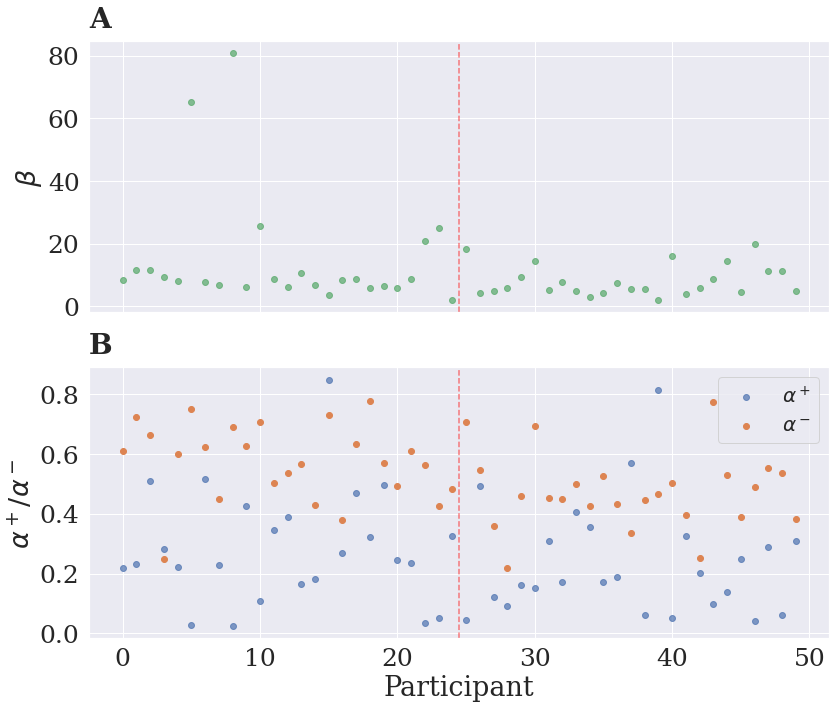

In [457]:
# plot average evolution
fig, ax = plt.subplots(2,1, figsize = (12,10))
ax[1].scatter(range(50),best_params_k[:,0], label= r"$\alpha^+$",alpha=0.7)
ax[1].scatter(range(50),best_params_k[:,1], label= r"$\alpha^-$",alpha=1)
ax[0].scatter(range(50),best_params_k[:,2], label= r"$\beta$",alpha=0.7,c="g")
ax[1].legend(prop={'size': 20})
ax[1].set_xlabel("Participant",size=27)
ax[0].set_ylabel(r"$\beta$",size=27)
ax[1].set_ylabel(r"$\alpha^+ / \alpha^-$",size=27)

ax[0].tick_params(axis='x', labelsize=25)
ax[0].tick_params(axis='y', labelsize=25)
ax[1].tick_params(axis='x', labelsize=25)
ax[1].tick_params(axis='y', labelsize=25)
ax[0].axvline(x=24.5,color="red",alpha=0.5,linestyle="--")
ax[1].axvline(x=24.5,color="red",alpha=0.5,linestyle="--")
ax[0].xaxis.set_ticklabels([])
ax[0].text(0,1.05,"A",transform=ax[0].transAxes,fontsize=28,weight='bold')
ax[1].text(0,1.05,"B",transform=ax[1].transAxes,fontsize=28,weight='bold')
plt.tight_layout()
plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig7.png',dpi=400)


### Task K - I

In [ ]:
log_lh_mod3 = []
for i in range(choices_oh.to_numpy().shape[0]):
    log_lh_mod3.append(log_lh_var([best_params_k[i,0],best_params_k[i,1],best_params_k[i,2]],choices_oh.to_numpy()[i,:],outcomes.to_numpy()[i,:]))

log_lh_mod3 = np.array(log_lh_mod3)

print("Average log-likelihood for model 1:",np.round(np.mean(log_lh_mod1),4))
print("Average log-likelihood for model 3:",np.round(np.mean(log_lh_mod3),4))

print("t-test p-value: ",np.round(scipy.stats.ttest_ind(log_lh_mod1,log_lh_mod3).pvalue,4))



In [ ]:
aic_mod1=np.sum(log_lh_mod1*2+2*2)
aic_mod3=np.sum(log_lh_mod3*2+2*3)

bic_mod1=np.sum(log_lh_mod1*2+2*np.log(160))
bic_mod3=np.sum(log_lh_mod3*2+3*np.log(160))
    
print("AIC for model 1: ",np.round(aic_mod1,2))
print("AIC for model 3: ",np.round(aic_mod3,2))
print("BIC for model 1: ",np.round(bic_mod1,2))
print("BIC for model 3: ",np.round(bic_mod3,2))

### Task K - J

In [ ]:
def rl_gen_var_j(alpha_0, alpha_1, beta, init_v):
    """
    RL for third model to simulate data
    """
    v = np.ones(2)*init_v
    out_list = []
    action_list = []
    for i in range(160):
        
        prob_a=0
        if i < 40:
            prob_a = 0.6
        elif i < 80:
            prob_a = 0.8
        elif i < 120:
            prob_a = 0.6
        else:
            prob_a = 0.65
        
        prob_b = 1-prob_a
        
        #action
        p_action_a = np.exp(-beta*v[0])/(np.exp(-beta*v[0])+np.exp(-beta*v[1]))
        
        if random.uniform(0,1)<p_action_a:
            a = 0
        else:
            a = 1
        
        
        out = outc(a,prob_a,prob_b)
        
        v[a] += ((1-out)*alpha_0+out*alpha_1)*(out-v[a])
        
        out_list.append(out)
        action_list.append(a)
        
    return out_list, action_list

In [ ]:
# simulate 3rd model

best_params_k_mod = best_params_k[np.logical_and(np.logical_and(best_params_k[:,0]<1,best_params_k[:,1]<1),best_params_k[:,2]<10)]


anx_mean = np.mean(best_params_k_mod[:25,:],axis=0)
ctrl_mean = np.mean(best_params_k_mod[25:,:],axis=0)

overall_median = np.median(best_params_k_mod,axis=0)

#set mode to diff if mean are different from the first 25 participants from the last 25

#experimental
overall_median = best_params_k_mod[0,:]

if mode == "diff":


    anx=np.random.multivariate_normal(anx_mean,[[0.01,0,0],[0,0.01,0],[0,0,0.5]],size=N//2)
    ctrl=np.random.multivariate_normal(ctrl_mean,[[0.01,0,0],[0,0.01,0],[0,0,0.5]],size=N//2)

    params = np.vstack((anx,ctrl))
else:


    params=np.random.multivariate_normal(overall_median,[[0.01,0,0],[0,0.01,0],[0,0,1]],size=N)



outcomes_synth = []
actions_synth = []
for param in params:
    
    outcome, actions = rl_gen_var_j(param[0],param[1],param[2],0.5)

    outcomes_synth.append(outcome)
    actions_synth.append(actions)
outcomes_synth_k = np.array(outcomes_synth)
actions_synth_k = np.array(actions_synth)


In [ ]:
# model fittings


best_params_02 = []
best_params_12 = []
best_params_20 = []
best_params_21 = []
best_params_22 = []

for i in range(N):
    res=optimize.minimize(log_lh,x0=[0.3,8],method='Nelder-Mead',args=(actions_synth_k[i,:],outcomes_synth_k[i,:]))
    best_params_02.append(res.x)
    res=optimize.minimize(log_lh_leaky,x0=[0.4,5,0.5],method='Nelder-Mead',args=(actions_synth_k[i,:],outcomes_synth_k[i,:]))
    best_params_12.append(res.x)
    res=optimize.minimize(log_lh_var,x0=[0.25,0.35,6],method='Nelder-Mead',args=(actions_synth_g[i,:],outcomes_synth_g[i,:]))
    best_params_20.append(res.x)
    res=optimize.minimize(log_lh_var,x0=[0.25,0.35,6],method='Nelder-Mead',args=(actions_synth_j[i,:],outcomes_synth_j[i,:]))
    best_params_21.append(res.x)
    res=optimize.minimize(log_lh_var,x0=[0.25,0.35,6],method='Nelder-Mead',args=(actions_synth_k[i,:],outcomes_synth_k[i,:]))
    best_params_22.append(res.x)
best_params_02 = np.array(best_params_02)
best_params_12 = np.array(best_params_12)
best_params_20 = np.array(best_params_20)
best_params_21 = np.array(best_params_21)
best_params_22 = np.array(best_params_22)





In [ ]:
#log_lh_mod1 = []



log_lh_mod_02 = []
log_lh_mod_12 = []
log_lh_mod_20 = []
log_lh_mod_21 = []
log_lh_mod_22 = []
for i in range(N):
    log_lh_mod_02.append(log_lh([best_params_02[i,0],best_params_02[i,1]],actions_synth_k[i,:],outcomes_synth_k[i,:]))
    log_lh_mod_12.append(log_lh_leaky([best_params_12[i,0],best_params_12[i,1],best_params_12[i,2]],actions_synth_k[i,:],outcomes_synth_k[i,:]))
    log_lh_mod_20.append(log_lh_var([best_params_20[i,0],best_params_20[i,1],best_params_20[i,2]],actions_synth_g[i,:],outcomes_synth_g[i,:]))
    log_lh_mod_21.append(log_lh_var([best_params_21[i,0],best_params_21[i,1],best_params_21[i,2]],actions_synth_j[i,:],outcomes_synth_j[i,:]))
    log_lh_mod_22.append(log_lh_var([best_params_22[i,0],best_params_22[i,1],best_params_22[i,2]],actions_synth_k[i,:],outcomes_synth_k[i,:]))

log_lh_mod_02 = np.array(log_lh_mod_02)
log_lh_mod_12 = np.array(log_lh_mod_12)
log_lh_mod_20 = np.array(log_lh_mod_20)
log_lh_mod_21 = np.array(log_lh_mod_21)
log_lh_mod_22 = np.array(log_lh_mod_22)





In [ ]:

aic_mod02=log_lh_mod_02*2+2*2
aic_mod12=log_lh_mod_12*2+2*3
aic_mod20=log_lh_mod_20*2+2*3
aic_mod21=log_lh_mod_21*2+2*3
aic_mod22=log_lh_mod_22*2+2*3

bic_mod02=log_lh_mod_02*2+2*np.log(160)
bic_mod12=log_lh_mod_12*2+3*np.log(160)
bic_mod20=log_lh_mod_20*2+3*np.log(160)
bic_mod21=log_lh_mod_21*2+3*np.log(160)
bic_mod22=log_lh_mod_22*2+3*np.log(160)

    
print("AIC for recovered model 1 data 3: ",np.round(np.sum(aic_mod02),2))
print("AIC for recovered model 2 data 3: ",np.round(np.sum(aic_mod12),2))
print("AIC for recovered model 3 data 1: ",np.round(np.sum(aic_mod20),2))
print("AIC for recovered model 3 data 2: ",np.round(np.sum(aic_mod21),2))
print("AIC for recovered model 3 data 3: ",np.round(np.sum(aic_mod22),2))
print("\n")
print("BIC for recovered model 1 data 3: ",np.round(np.sum(bic_mod02),2))
print("BIC for recovered model 2 data 3: ",np.round(np.sum(bic_mod12),2))
print("BIC for recovered model 3 data 1: ",np.round(np.sum(bic_mod20),2))
print("BIC for recovered model 3 data 2: ",np.round(np.sum(bic_mod21),2))
print("BIC for recovered model 3 data 3: ",np.round(np.sum(bic_mod22),2))



In [ ]:
print("t-statistic for alpha+ test: ", np.round(scipy.stats.ttest_ind(best_params_k[:25,:],best_params_k[25:,:]).statistic[0],4))
print("t-statistic for alpha- test: ", np.round(scipy.stats.ttest_ind(best_params_k[:25,:],best_params_k[25:,:]).statistic[1],4))
print("t-statistic for beta test: ", np.round(scipy.stats.ttest_ind(best_params_k[:25,:],best_params_k[25:,:]).statistic[2],4))


print("Degrees of freedom: ",48)
print("p-value for alpha+ test: ", np.round(scipy.stats.ttest_ind(best_params_k[:25,:],best_params_k[25:,:]).pvalue[0],4))
print("p-value for alpha- test: ", np.round(scipy.stats.ttest_ind(best_params_k[:25,:],best_params_k[25:,:]).pvalue[1],4))
print("p-value for beta test: ", np.round(scipy.stats.ttest_ind(best_params_k[:25,:],best_params_k[25:,:]).pvalue[2],4))



In [ ]:
np.mean(best_params_k[25:,1])

In [ ]:
# Preparing data for confusion matrix with AIC

aic_data=np.ones((N*3,))
aic_data[:N]=0
aic_data[2*N:]=2



aic_mod0=np.vstack((aic_mod00,aic_mod10,aic_mod20)).T
aic_mod1=np.vstack((aic_mod01,aic_mod11,aic_mod21)).T
aic_mod2=np.vstack((aic_mod02,aic_mod12,aic_mod22)).T

aic_mod0_ind = np.argmin(aic_mod0,axis=1)
aic_mod1_ind = np.argmin(aic_mod1,axis=1)
aic_mod2_ind = np.argmin(aic_mod2,axis=1)

aic_mod = np.hstack((aic_mod0_ind,aic_mod1_ind,aic_mod2_ind))


In [ ]:
aic_cm=confusion_matrix(aic_data,aic_mod)

In [ ]:
# Preparing data for confusion matrix with BIC



bic_data=np.ones((N*3,))
bic_data[:N]=0
bic_data[2*N:]=2


bic_mod0=np.vstack((bic_mod00,bic_mod10,bic_mod20)).T
bic_mod1=np.vstack((bic_mod01,bic_mod11,bic_mod21)).T
bic_mod2=np.vstack((bic_mod02,bic_mod12,bic_mod22)).T

bic_mod0_ind = np.argmin(bic_mod0,axis=1)
bic_mod1_ind = np.argmin(bic_mod1,axis=1)
bic_mod2_ind = np.argmin(bic_mod2,axis=1)

bic_mod = np.hstack((bic_mod0_ind,bic_mod1_ind,bic_mod2_ind))

In [ ]:
bic_cm=confusion_matrix(bic_data,bic_mod)

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots(1,2, figsize = (14,6))

sns.heatmap(aic_cm,cmap="Blues",annot=True,xticklabels=["Model 1","Model 2","Model 3"],yticklabels=["  Model 1","  Model 2","  Model 3"],ax=ax[0],square=True,fmt="g",annot_kws={"fontsize":18})
sns.heatmap(bic_cm,cmap="Blues",annot=True,xticklabels=["Model 1","Model 2","Model 3"],yticklabels=["   Model 1","   Model 2","   Model 3"],ax=ax[1],square=True,fmt="g",annot_kws={"fontsize":18})

ax[0].tick_params(axis='x', labelsize=18)


ax[0].text(0,1.05,"A",transform=ax[0].transAxes,fontsize=28,weight='bold')
ax[1].text(0,1.05,"B",transform=ax[1].transAxes,fontsize=28,weight='bold')
plt.tight_layout()
plt.show()


In [ ]:
#Plot normalized confusion matrix

fig, ax = plt.subplots(1,2, figsize = (14,6))

sns.heatmap(aic_cm/500,cmap="Blues",annot=True,xticklabels=["1","2","3"],yticklabels=["  1","  2","  3"],ax=ax[0],square=True,fmt="g",annot_kws={"fontsize":25})
sns.heatmap(bic_cm/500,cmap="Blues",annot=True,xticklabels=["1","2","3"],yticklabels=["   1","   2","   3"],ax=ax[1],square=True,fmt="g",annot_kws={"fontsize":25})

ax[0].tick_params(axis='x', labelsize=25)
ax[0].tick_params(axis='y', labelsize=25)
ax[1].tick_params(axis='x', labelsize=25)
ax[1].tick_params(axis='y', labelsize=25)

ax[0].set_xlabel("Fit model",size=28)
ax[0].set_ylabel("Simulated model",size=28)

ax[1].set_xlabel("Fit model",size=28)


ax[0].text(0,1.05,"A",transform=ax[0].transAxes,fontsize=28,weight='bold')
ax[1].text(0,1.05,"B",transform=ax[1].transAxes,fontsize=28,weight='bold')
plt.tight_layout()
plt.show()
fig.savefig('/Users/josehernandez/Documents/The University of Edinburgh/Academics/SEM2/CCN/Assignment 2/Plots/fig8.png',dpi=400,bbox_inches='tight')

